## Code to Calculate Phase of Precipitation from Monthly data (climo or timseries or h0 files)

In [1]:
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cftime
import dask as dk

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.feature as cf

import matplotlib.pyplot as mp
from matplotlib.colors import ListedColormap

from mpl_toolkits.axes_grid1 import AxesGrid

import glob


from distributed import Client, LocalCluster
from ncar_jobqueue import NCARCluster

In [2]:
#cluster = NCARCluster()
#cluster.scale(10)
#client = Client(cluster)
#client

In [3]:
''' Routines to process input data and return variable or creat variable specifc climo file '''

mnames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
projection = ccrs.PlateCarree()
cmap1 = ListedColormap(['mediumslateblue', 'blue','cornflowerblue','cyan','c','green','bisque','yellow','darkorange','orangered','pink','deeppink'])
#cmap2 = ListedColormap(['w','lavender','mediumpurple','rebeccapurple','indigo','darkblue','mediumblue','blue','darkgreen','green','yellowgreen','yellow','gold','orange','darkorange','orangered','red','firebrick','darkred','salmon','indianred','lightcoral','pink','hotpink'])
cmap2 = ListedColormap(['w','lavender','mediumpurple','rebeccapurple','indigo','darkblue','mediumblue','blue','darkgreen','green','yellowgreen','yellow','gold','orange','darkorange','orangered','red','firebrick','darkred','salmon'])

letts = ['(a)','(b)','(c)']





''' Grab and/or construct monthly climos '''

def get_mon_climos(case,case_df,var,var_df,years):
    
    lexist = case_df.loc[case,'lcexist'] 
    run_name = case_df.loc[case,'rname'] 
    case_dir = case_df.loc[case,'cdir']                        
    lobs = case_df.loc[case,'lobs']
    fin_type =  case_df.loc[case,'cclimo']
    
    vscale = var_df.loc[var,'voscale'] if lobs else var_df.loc[var,'vscale'] 

    
  
    

# Obs. always assume same structure and that they exist.
    if lobs:
        
        print('-Observations case')
        
        files_in = case_dir+case+'_??_climo.nc'
        
        flist = sorted(glob.glob(files_in))

        print(' -> First/last files = \n '+ \
              flist[0]+' \n '+flist[-1])
        
        ds_case = xr.open_mfdataset(flist,engine='netcdf4', decode_times = False, combine = 'nested') 
        ds_case['time'] = pd.to_datetime(pd.date_range("2000", freq="M", periods=12))
     
        var_climo = ds_case[var]
        

        
#### Grab existing full or var specific climo file

    else :

        print('-Model case')
        
# Do the existing model climos exist?
        
        if (lexist):
            
            print('-Full Climo files exist')
            
            case_dir = '/glade/scratch/cmip6/archive/'+run_name+'/atm/proc/climo/'+run_name+'/'+run_name+'.'+years[0]+'-'+years[1]+'/'
        
            files_in = case_dir+run_name+'.cam.h0.'+years[0]+'-'+years[1]+'._??_climo.nc'
        
            flist = sorted(glob.glob(files_in))
        

            print(' -> First/last files = \n '+ \
              flist[0]+' \n '+flist[-1])
        
#            ds_case = xr.open_mfdataset(flist,engine='netcdf4', decode_times = False, combine = 'nested') 
            ds_case = xr.open_mfdataset(flist,engine='netcdf4')
            ds_case['time'] = pd.to_datetime(pd.date_range("2000", freq="M", periods=12))
     
            var_climo = ds_case['PRECC']+ds_case['PRECL']
            
            
        else:
            
            '''
             Are they in tseries format?  
            '''
    
            if fin_type == 'tseries':
        
                print('-Time series files')
        
                if case == 'CESM2':
                    files_in = case_dir+var+'/'+run_name+'.cam.h0.'+var+'*.nc'
                    
                    
                    flist = sorted(glob.glob(files_in))
                    ds_case = xr.open_mfdataset(files_in,engine='netcdf4') 
                    ds_case = ds_case.sel(time=slice(years[0],years[1]))
                    var_in = ds_case[var]
                    
                     
                    
                    
                        
                if case == 'E3SMv2':
                    if var=='PRECT':
                        files_in = case_dir+'/'+run_name+'/atm/proc/tseries/month_1/'+run_name+'.eam.h0.PRECC*.nc'
                        lfiles_in = case_dir+'/'+run_name+'/atm/proc/tseries/month_1/'+run_name+'.eam.h0.PRECL*.nc'
                        
                        flist = sorted(glob.glob(files_in))
                        lflist = sorted(glob.glob(lfiles_in))
                        
                        ds_case = xr.open_mfdataset(files_in,engine='netcdf4') 
                        lds_case = xr.open_mfdataset(lfiles_in,engine='netcdf4') 
                        
                        ## Subset for required years.
                        ds_case = ds_case.sel(time=slice(years[0],years[1]))
                        var_in = ds_case['PRECC']
                        
                        lds_case = lds_case.sel(time=slice(years[0],years[1]))
                        lvar_in = lds_case['PRECL']
                        
                        var_in += lvar_in
                       
                                               
                    else:
                        
                        files_in = case_dir+'/'+run_name+'/atm/proc/tseries/month_1/'+run_name+'.eam.h0.'+var+'*.nc'
                      
                        flist = sorted(glob.glob(files_in))
                        
                        ds_case = xr.open_mfdataset(files_in,engine='netcdf4') 
               
                        ds_case = ds_case.sel(time=slice(years[0],years[1]))
                        var_in = ds_case[var]
                
                print('-> First/last files = \n '+ \
                    flist[0]+' \n '+flist[-1])
                

    

                
## name of years and months        
                mnames_all = ds_case.time.dt.strftime("%b") 
                year_all = ds_case.time.dt.strftime("%Y") 

## Initialize climo array
                var_climo = var_in[0:12,:,:]
                var_climo['time'] = pd.to_datetime(pd.date_range("2000-01", freq="M", periods=12))

                

## Loop imonths and month names
                for im,imname in enumerate(mnames) :    ## Construct monthly climos.
                    imon_ts = mnames_all == imname
                    var_climo[im-1,:,:] = var_in[imon_ts,:,:].mean(dim='time')
                
#                var_climo=var_in.groupby('time.monthofyear').mean()
             
            
                '''            
                    Or h0 history format?
                '''            
            else: 
                
## Write file out.
                print('-> Writing climo files out')
        
    
        var_climo = vscale*var_climo
    
    return var_climo













''''''
''' Calculate Monthly Phase of Maximum and Minimum '''
''''''

def calc_mon_phase(var_climo):
    
    
## Calculate the phase min and max of climo. data at each grid point.
    
    mnames = var_climo.time.dt.strftime("%b") 
    
    phase_min = var_climo.argmin(dim='time').values
    phase_max = var_climo.argmax(dim='time').values
    
    climo_phase_max= xr.DataArray(phase_max, coords=[var_climo.lat, var_climo.lon], dims=["lat", "lon"])
    climo_phase_min= xr.DataArray(phase_min, coords=[var_climo.lat, var_climo.lon], dims=["lat", "lon"])
    
    
    return climo_phase_min,climo_phase_max



In [4]:
'''
    Run Specs.
'''

case_names = ['GPCP','CESM2','E3SMv2']
#case_names = ['GPCP','GPCP','GPCP']

var_name = 'PRECT' ; vscale = 86400.*1000.
cyears = ['2081','2100']
lsave = True


# For the phase diagrma
lone,lonw,lats,latn = 60.,120.,0.,30.
lat_lon = (60,120,0,30)

# For the time/lat monsonon plot.
lonm_w = 70 ; lonm_e = 100.
latm_s = 0.; latm_n = 40. 


In [5]:
'''
    Derived info.
'''

dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'
dir_e3sm = '/glade/campaign/cgd/ccr/E3SMv2/FV_regridded/'
dir_cesm2 = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/'


##### Case dictionary #####

case_dic = {}

case_dic['GPCP']  = ['climo','GPCP',True,dir_obs,True]

case_dic['E3SMv2']  = ['tseries','v2.FV1.SSP370_0101',False,dir_e3sm,False]
case_dic['CESM2'] = ['tseries','b.e21.BSSP370cmip6.f09_g17.LE2-1001.001',False,dir_cesm2,False]

#case_dic['E3SMv2']  = ['tseries','v2.FV1.historical_0101',False,dir_e3sm,False]
#case_dic['CESM2'] = ['tseries','b.e21.BHISTcmip6.f09_g17.LE2-1001.001',False,dir_cesm2,False]


#case_dic['CESM2'] = ['tseries','b.e21.BHIST.f09_g17.CMIP6-historical.011',True,dir_cesm2,False]

# Name wrapper.
case_df = pd.DataFrame.from_dict(case_dic, orient='index',columns=['cclimo','rname','lcexist','cdir','lobs'])

##### Var dictionary #####

var_dic = {}
var_dic['PRECT']  = ['Total Pecipitation','mm/day','PRECT',86400*1000.,1.]
# Var wrapper.
var_df = pd.DataFrame.from_dict(var_dic, orient='index',columns=['vlname','vunits','voname','vscale','voscale'])



-Processing data for GPCP
-Observations case
 -> First/last files = 
 /glade/p/cesm/amwg/amwg_data/obs_data/GPCP_01_climo.nc 
 /glade/p/cesm/amwg/amwg_data/obs_data/GPCP_12_climo.nc
<xarray.DataArray 'time' ()>
array('2000-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-12-31
<xarray.DataArray 'PRECT' (time: 12, lat: 72)>
dask.array<mean_agg-aggregate, shape=(12, 72), dtype=float32, chunksize=(12, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2000-12-31
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

-Processing data for CESM2
-Model case
-Time series files


/glade/scratch/rneale/ipykernel_11702/636916009.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2[ic].set_xticklabels(mnames)


-> First/last files = 
 /glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/PRECT/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.cam.h0.PRECT.201501-202412.nc 
 /glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/PRECT/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.cam.h0.PRECT.209501-210012.nc


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geome

<xarray.DataArray 'time' ()>
array('2000-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-12-31
<xarray.DataArray 'PRECT' (time: 12, lat: 192)>
dask.array<mean_agg-aggregate, shape=(12, 192), dtype=float32, chunksize=(12, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2000-12-31

-Processing data for E3SMv2
-Model case
-Time series files


/glade/scratch/rneale/ipykernel_11702/636916009.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2[ic].set_xticklabels(mnames)


-> First/last files = 
 /glade/campaign/cgd/ccr/E3SMv2/FV_regridded//v2.FV1.SSP370_0101/atm/proc/tseries/month_1/v2.FV1.SSP370_0101.eam.h0.PRECC.201501-210012.nc 
 /glade/campaign/cgd/ccr/E3SMv2/FV_regridded//v2.FV1.SSP370_0101/atm/proc/tseries/month_1/v2.FV1.SSP370_0101.eam.h0.PRECC.201501-210012.nc


/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geome

<xarray.DataArray 'time' ()>
array('2000-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-12-31
<xarray.DataArray 'PRECC' (time: 12, lat: 192)>
dask.array<mean_agg-aggregate, shape=(12, 192), dtype=float32, chunksize=(12, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.76 -89.06 -88.12 -87.17 ... 88.12 89.06 89.76
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2000-12-31


/glade/scratch/rneale/ipykernel_11702/636916009.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2[ic].set_xticklabels(mnames)


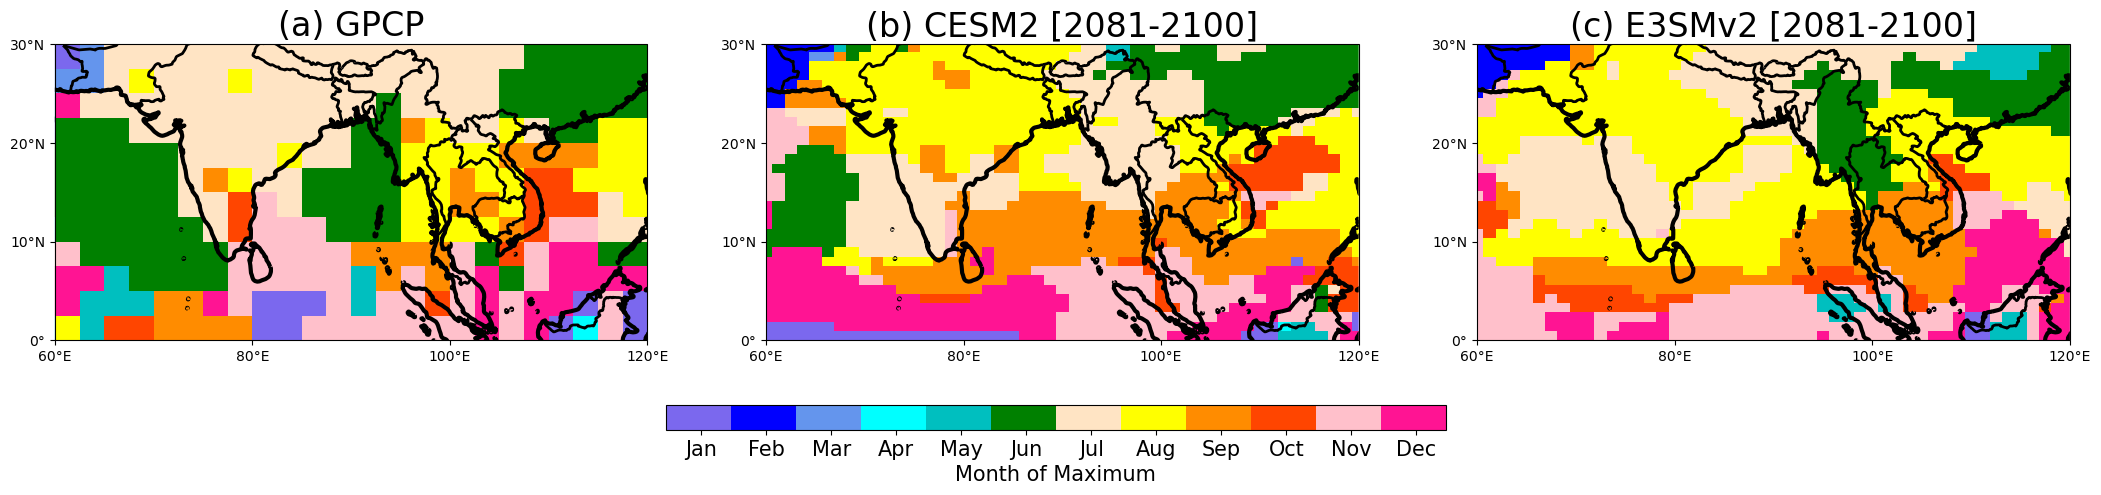

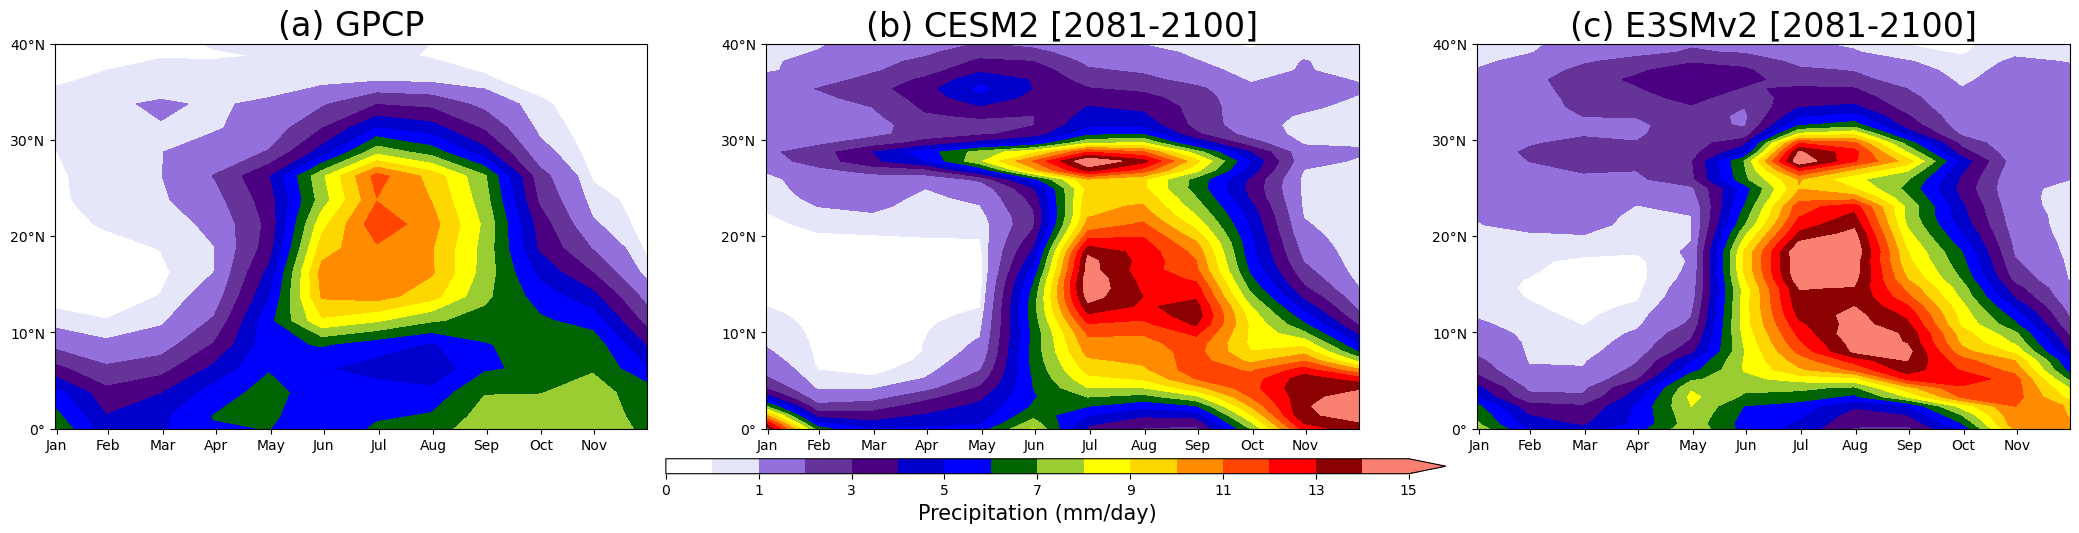

In [9]:
'''
    Main Code Logic with Plots
'''

#fig = mp.figure(figsize=(26, 8))
#ax = mp.subplot(1,1,2, projection=projection)

fig1, ax1 = mp.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': projection},
                        figsize=(26,5))
mp.figure(1)

fig2, ax2 = mp.subplots(nrows=1,ncols=3,figsize=(26,5))

mp.figure(2)


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()




''' LOOP CASES '''

for ic,case_name in enumerate(case_names):
    
  


    print('')
    print('-Processing data for '+case_name)
    
    
# Monthly climos (nmonth,nlat,nlon)
    data_climo = get_mon_climos(case_name,case_df,var_name,var_df,cyears)
# Month phase of maximum and minimum
    phase_min,phase_max = calc_mon_phase(data_climo)
    
    

    '''''
        Plotting For Phase Max
    '''''

    lons = phase_max.lon
    lats = phase_max.lat
    
 


    # make the color map:
   
    mp.figure(1)

    pphase = ax1[ic].pcolormesh(lons, lats, phase_max,transform=projection,cmap=cmap1)
       
    ax1[ic].xaxis.set_major_formatter(lon_formatter)
    ax1[ic].yaxis.set_major_formatter(lat_formatter)
    
    ax1[ic].set_extent(lat_lon)
    ax1[ic].add_feature(cf.COASTLINE, lw=3)
    ax1[ic].add_feature(cf.BORDERS,lw=2)
    
    
    this_title= letts[ic]+' '+case_name+' ['+cyears[0]+'-'+cyears[1]+']' if case_name != 'GPCP' else letts[ic]+' '+case_name
    
    ax1[ic].set_title(this_title,fontsize=24)    
    
    ax1[ic].set_ylim(lat_lon[2],lat_lon[3])
    
    ax1[ic].set_xticks(np.arange(lat_lon[0], lat_lon[1]+20, 20), crs=projection)
    ax1[ic].set_yticks(np.arange(lat_lon[2], lat_lon[3]+10, 10), crs=projection)
        
    mp.figure(2)
   




    '''
        Month/lat plot
    '''
        
    mon_lat_time = data_climo.sel(lon=slice(lonm_w,lonm_e)).mean(dim='lon')
        
    mplevs = [0,0.5,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    pcont = ax2[ic].contourf(mon_lat_time.time, lats, mon_lat_time.transpose(),levels = mplevs,cmap=cmap2,extend='max') 
    
    
    ax2[ic].set_title(this_title,fontsize=24)    
#    ax2[ic].set_xticks(range(len(mon_lat_time.time)))
#    ax2[ic].get_xticks()
    print(mon_lat_time.time[-1])
#    ax2[ic].set_xlim(mon_lat_time.time[0],mon_lat_time.time[-1]+0.001)
    print(mon_lat_time)
#    print(mon_lat_time.time.dt.strftime("%b"))
    
    ax2[ic].set_xticklabels(mnames)
    ax2[ic].set_yticks(np.arange(lat_lon[2], lat_lon[3]+20, 10))
    ax2[ic].yaxis.set_major_formatter(lat_formatter)
    ax2[ic].set_ylim(latm_s,latm_n)
    
    

    
    mp.rc('xtick', labelsize=10) 
    mp.rc('ytick', labelsize=10) 
    
        
# Draw the colorbar
# Add a colorbar axis at the bottom of the graph

'''
 Fig 1
'''

mp.figure(1)
        
cbar_ax1 = fig1.add_axes([0.36, 0.02, 0.3, 0.05])
colb1=mp.colorbar(pphase, cax=cbar_ax1,orientation='horizontal',ticks = 0.5+(11/12)*np.arange(np.min(phase_max),np.max(phase_max)+1))

colb1.ax.set_xticklabels(mnames,fontsize=15)
colb1.set_label('Month of Maximum',fontsize=15)



mp.savefig('CESM2_E3SM_Monsoon_phase_future.png', dpi=200,bbox_inches='tight') 

'''
 Fig 2
'''

mp.figure(2)



        
cbar_ax2 = fig2.add_axes([0.36, 0.02, 0.3, 0.03])
colb2=fig2.colorbar(pcont, cax=cbar_ax2,orientation='horizontal')

colb2.set_label('Precipitation (mm/day)',fontsize=15)

mp.savefig('CESM2_E3SM_Monsoon_extent_future.png', dpi=200,bbox_inches='tight') 



        



    


    
    



In [7]:
'''
Plots of monthly variation of Monsoon extent
'''





'\nPlots of monthly variation of Monsoon extent\n'